In [ ]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError


In [ ]:
y_train= pd.read_csv("/content/y_train.csv")
y_train=y_train['BBclass']
y_test=pd.read_csv("/content/y_external.csv")
y_test=y_test['BBclass']
x_test=pd.read_csv("/content/X_external.csv")
x_train=pd.read_csv("/content/X_train.csv")

In [ ]:
#error방지를 위해 변수명에 쉼표와 부등호 다 없애기
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_train.columns.values]
x_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_test.columns.values]

# 2차원으로 차원 축소, t-sne 모델 생성

In [ ]:
#auto보다 연속적인 형태일 때 더 잘 돼
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=42)
k=model.fit_transform(x_train, y_train)


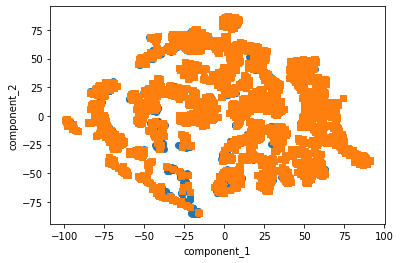

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
col=['component_1','component_2']
train_set=pd.DataFrame(k, columns=col)
train_set['target']=y_train

markers=['o','s']
for i,marker in enumerate(markers):
  x_axis_data=train_set[train_set['target']==i]['component_1']
  y_axis_data=train_set[train_set['target']==i]['component_2']
  plt.scatter(x_axis_data, y_axis_data, marker=marker)

plt.xlabel('component_1')
plt.ylabel('component_2')
plt.show()

#autoencoder 이용한 차원 축소

In [ ]:
#데이터 표준화 시켜준다.
from sklearn.preprocessing import MinMaxScaler

def scale_datasets(x_train, x_test):

  standard_scaler = MinMaxScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
  
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

#AutoEncoder생성
class AutoEncoders(Model):

  def __init__(self, output_units):

    super().__init__()
    self.encoder = Sequential(
        [
          Dense(32, activation="relu"),
          Dense(16, activation="relu"),
          Dense(7, activation="relu")
        ]
    )

    self.decoder = Sequential(
        [
          Dense(16, activation="relu"),
          Dense(32, activation="relu"),
          Dense(output_units, activation="sigmoid")
        ]
    )

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
auto_encoder = AutoEncoders(len(x_train_scaled.columns))

auto_encoder.compile(
    loss='RMSE',
    optimizer='RMSPROP'
)

history = auto_encoder.fit(
    x_train_scaled, 
    x_train_scaled, 
    epochs=15, 
    batch_size=32, 
    validation_split=0.2)



Epoch 1/15
180/180 [==============================] - 2s 8ms/step - loss: 0.2229 - val_loss: 0.1912
Epoch 2/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1823 - val_loss: 0.1762
Epoch 3/15
180/180 [==============================] - 1s 6ms/step - loss: 0.1752 - val_loss: 0.1719
Epoch 4/15
180/180 [==============================] - 1s 6ms/step - loss: 0.1705 - val_loss: 0.1666
Epoch 5/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1651 - val_loss: 0.1616
Epoch 6/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1602 - val_loss: 0.1565
Epoch 7/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1577 - val_loss: 0.1557
Epoch 8/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1562 - val_loss: 0.1549
Epoch 9/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1552 - val_loss: 0.1538
Epoch 10/15
180/180 [==============================] - 1s 5ms/step - loss: 0.1544 - val_loss: 0.1525

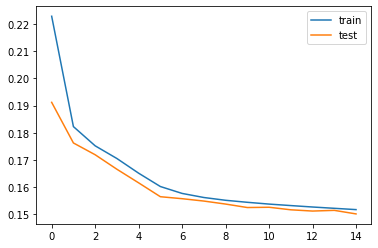

In [ ]:
#그림으로 확인
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
#테스트셋에 적용시킨다.
performance_test = auto_encoder.evaluate(x_test_scaled, x_test_scaled, batch_size=100)


1/1 [==============================] - 0s 22ms/step - loss: 0.1486
